# M3: Targeted to Global Conversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# import os ; replaced below
from pathlib import Path

In [4]:
# consider simplifying to assume input files and if not found, create

SEARCH_MSG = \
    f"> Select a folder to add it to the path and search inside.\n" \
    f"> Select a file to finish the search process.\n" \
    f"> To select option [#], enter #.\n" \
    f"[E] Exit\n" \
    f"[U] Search up one level"

def findFile(input_path):
    current_path = Path(input_path)
    if not current_path.exists():
        return("Invalid Path")
    print(f"Current path: {current_path}")
    print(SEARCH_MSG)
    
    # list out files with [#] as identifier
    dirList = [f for f in current_path.iterdir()]
    print("> Files in current folder:")
    for c, i in enumerate(dirList):
        print('[' + str(c) + '] ' + str(i.name))
    print("")

    choice = input()
    while choice.lower() not in ["u", "e"] + list(str(i) for i in range(len(dirList))):
        choice = input("Couldn't read input, trying again. Target #: ")

    if choice.lower() == "e": return("Exiting.")
    if choice.lower() == "u": return(findFile(current_path.parent))
    if choice.isnumeric() and int(choice) in range(len(dirList)):
        name = dirList[int(choice)]
        current_path = current_path / name

        if current_path.is_dir():
            print(f"Selected folder to search: {current_path}")
            return(findFile(current_path))
        if current_path.is_file():
            print(f"Selected file: {current_path}")
            return current_path

    return("Error reading choice, exiting.")

In [5]:
data_path = findFile(Path.cwd())
print(data_path)

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/scripts
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
> Files in current folder:
[0] su25 script.ipynb
[1] wi25 lab data script.ipynb
[2] wi25 lab data script.py

Exiting.


In [ ]:
if data_path != Path.cwd().parent / Path('input files/su25/M3 wavelengths targeted global clean.csv'):
    print("path updated")
    data_path = Path.cwd().parent / Path('input files/su25/M3 wavelengths targeted global clean.csv')
else:
    print("path unchanged")

data_path = Path('/Users/markus/Documents/Productivity/SETI/m3-lunar-project/input files/lunar_analog_spectra/Pyroxene lab spectra FDL/USGS augite WS592.csv')
data_path

path updated


PosixPath('/Users/markus/Documents/Productivity/SETI/m3-lunar-project/input files/lunar_analog_spectra/Pyroxene lab spectra FDL/USGS augite WS592.csv')

In [113]:
df = pd.read_csv(data_path).dropna()

In [114]:
df.head()

,Wavelength (nm),Augite ws592 spliced
0,301.1,0.045344
1,305.1,0.047974
2,309.1,0.049266
3,313.1,0.054325
4,317.1,0.058099


In [11]:
df.describe()

,Wavelength (µm) M3 targeted images,Wavelength (µm) M3 global images
count,85.000000,85.000000
mean,0.865223,1.575573
std,0.246345,0.701542
min,0.446020,0.461000
25%,0.655620,1.010000
50%,0.865220,1.429200
75%,1.074800,2.137800
max,1.284400,2.976200


In [14]:
# process:
# change step size if past a breakpoint
# format:
# current wl: step to transition to
breakpoints = {
    "wl"   : [0, 0.44, 0.68, 0.71, 1.53, 1.56, 1.60], # 9999],
    "step" : [0,    4,    4,    3,    2,    3,    4]  #    4]
}

# print(f"Enter 'd' to process with wavelength and spectra in columns 1 and 2 respectively. Enter 'c' to choose column numbers. Enter 'e' to exit.")
# ans = input()
# while ans not in ['d', 'c', 'e']:
#     ans = input()
# if ans == 'd':

try:
    wavelengths = np.array(df[df.columns[0]])
except:
    print(f"wavelength column not found")

print(f"wl shape: {wavelengths.shape}")
wl_nans = np.isnan(wavelengths).sum()
if wl_nans > 0:
    print(f"wavelength nans: {np.isnan(wavelengths).sum()}")
    print(f"wavelength nan indices: {np.where(np.isnan(wavelengths))[0]}")


try:
    spectra = np.array(df[df.columns[1]])
except:
    print(f"spectra column not found")

print(f"spectra shape: {spectra.shape}")
spectra_nans = np.isnan(spectra).sum()
if spectra_nans > 0:
    print(f"spectra nans: {np.isnan(spectra).sum()}")
    print(f"spectra nan indices: {np.where(np.isnan(spectra))[0]}")

wl shape: (85,)
spectra shape: (85,)


In [ ]:
# used to find breakpoints and compare to empirical process
# empirical = np.array(df[df.columns[-1]].dropna())
# if testing:
#         print(f"\nlengths:\n" + f"output    {len(output)}\n" + f"empirical {len(empirical)}\n")
#         print(f"sum diff:  {sum(output - empirical):f}")

#         print(f"\n" + f"idx: generated vs empirical")
#         for i in range(min(len(output), len(empirical))):
#             if empirical[i] != output[i]:
#                 print(f"{i}: {output[i]:.04f} | {empirical[i]:.04f}")

In [32]:
# average 4 at a time
# set step size to last breakpoint
# increment by step size
# round to 4 decimals

def targeted_to_global(wavelengths, spectra, verbose = False):
    WIDTH = 7
    if verbose: print(f"{'wl':>{WIDTH}}: step, index change")

    i = 0 # input index
    bp_idx = 0
    output = {"wavelengths": [], "spectra": []}
    while i+3 < len(wavelengths):
        # average over next 4
        avg_wl = np.round(np.mean(wavelengths[i:i+4]),4)
        avg_spectra = np.round(np.mean(spectra[i:i+4]),4)

        # if next step exists
        # and current wl > bp_idx wl
        while bp_idx + 1 < len(breakpoints["step"]) and wavelengths[i] > breakpoints["wl"][bp_idx]:
            bp_idx += 1
            if verbose: print(f"{wavelengths[i]:{WIDTH}.{WIDTH-2}f}: {breakpoints['step'][bp_idx-1]}->{breakpoints['step'][bp_idx]}, {bp_idx-1}->{bp_idx}")

        # save and increment by values consumed
        output["wavelengths"].append(avg_wl)
        output["spectra"].append(avg_spectra)
        i += breakpoints["step"][bp_idx]
    
    output["wavelengths"] = np.array(output["wavelengths"])
    output["spectra"] = np.array(output["spectra"])
    return output

In [33]:
targeted_to_global(wavelengths, spectra, verbose=True)

     wl: step, index change
0.44602: 0->4, 0->1
0.44602: 4->4, 1->2
0.68556: 4->3, 2->3
0.71551: 3->2, 3->4


{'wavelengths': array([0.461 , 0.5009, 0.5408, 0.5808, 0.6207, 0.6606, 0.7005, 0.7305,
        0.7504, 0.7704, 0.7904, 0.8103, 0.8303, 0.8502, 0.8702, 0.8902,
        0.9101, 0.9301, 0.9501, 0.97  , 0.99  , 1.0099, 1.0299, 1.0499,
        1.0698, 1.0898, 1.1098, 1.1297, 1.1497, 1.1696, 1.1896, 1.2096,
        1.2295, 1.2495, 1.2694]),
 'spectra': array([0.5209, 0.6781, 0.7804, 0.8602, 0.9401, 1.02  , 1.0998, 1.1596,
        1.1996, 1.2395, 1.2794, 1.3194, 1.3593, 1.3992, 1.4392, 1.479 ,
        1.519 , 1.5689, 1.6388, 1.7186, 1.7984, 1.8783, 1.9581, 2.038 ,
        2.1178, 2.1977, 2.2775, 2.3574, 2.4372, 2.5171, 2.5969, 2.6768,
        2.7566, 2.8364, 2.9163])}

In [ ]:
### inconsistencies
## round up, not truncating
# mean(0.99497, 1.005, 1.0149, 1.0249) = 1.0099425 -> 1.0099, manual is 1.01 > 1.0099
## round down
# mean(2.3624, 2.3724, 2.3823, 2.3923) = 2.37735 -> 2.3774, manual is 2.3773 < 2.3774

(85,)
(35,)


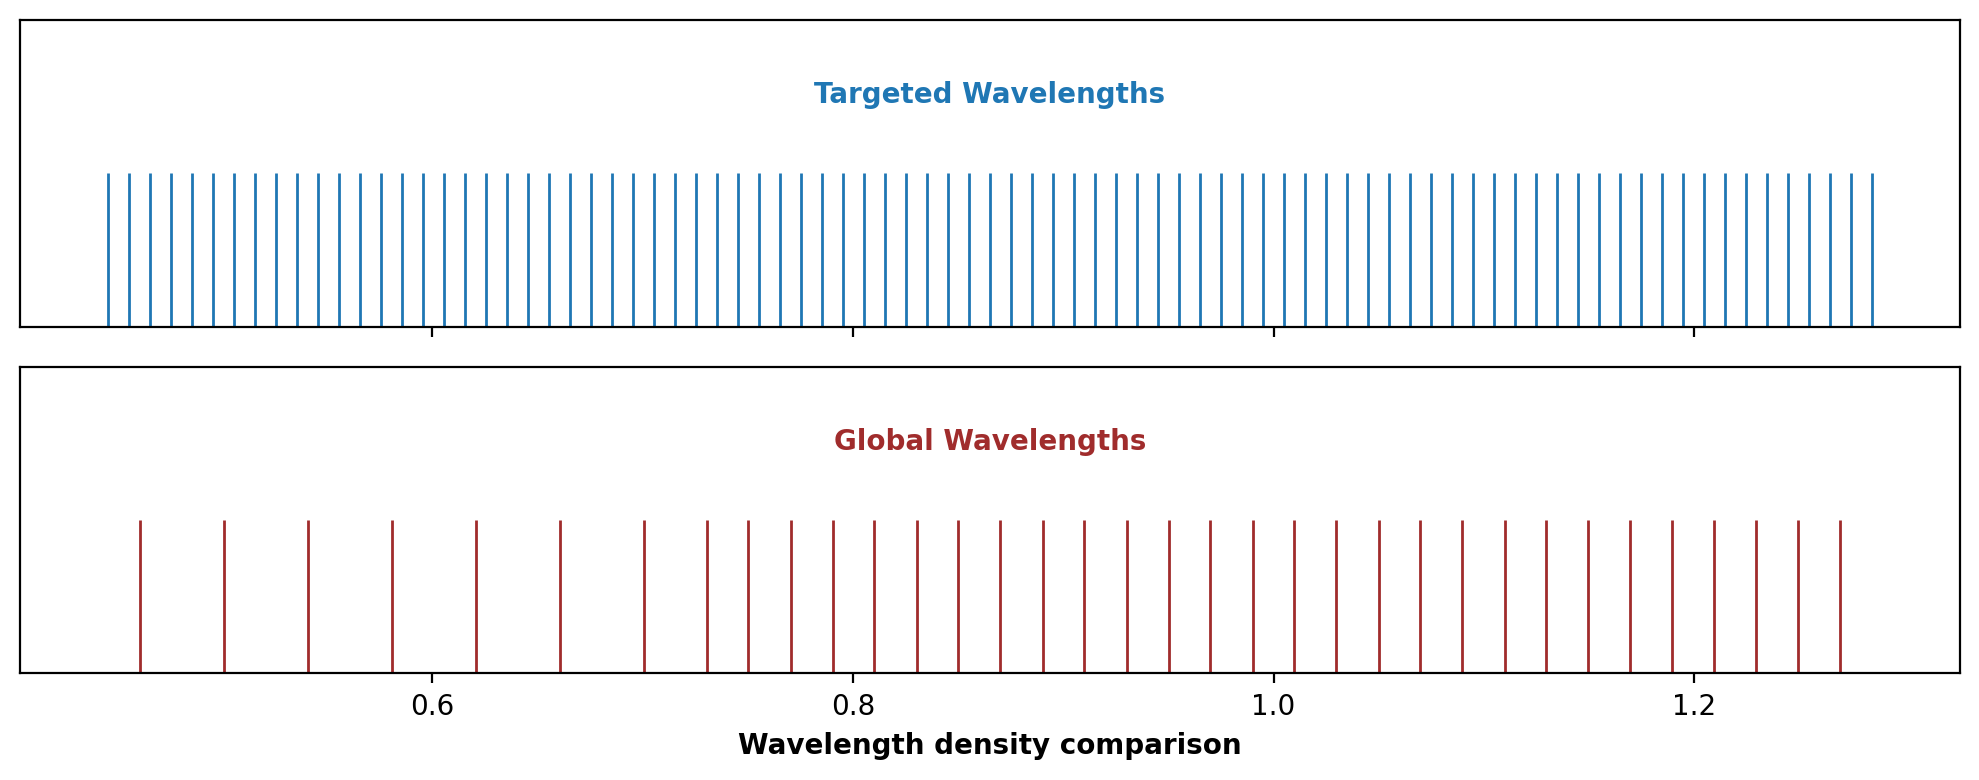

In [96]:
plotting = True
if plotting:

    data = {
        "Targeted Wavelengths": wavelengths, 
        # "Empirical M3": empirical, 
        "Global Wavelengths": targeted_to_global(wavelengths, spectra)["wavelengths"]
    }

    print(data['Targeted Wavelengths'].shape)
    print(data['Global Wavelengths'].shape)

    colors = ['#1f77b4', "#a02c2c"]
    fig, axes = plt.subplots(
        nrows=2,
        sharex=True, 
        figsize=(10, 4), 
        height_ratios=[1, 1]
    )

    # each series as a rug plot with its own row
    for ax, (label, series), color in zip(axes, data.items(), colors):
        sns.rugplot(x = series, ax = ax, height = 0.5, color = color)
        ax.set_yticks([])  # No y-axis ticks
        ax.set_ylabel("")
        ax.text(
            0.5, # x offset
            0.8, # y offset
            label, # text content
            # **kwargs
            transform=ax.transAxes, 
            ha='center', 
            va='top', 
            fontsize=10, 
            color=color, 
            weight='bold'
        )

    # last plot label acts as legend label
    axes[-1].set_xlabel("Wavelength density comparison", weight = 'bold') 
    plt.tight_layout()

    # plt.savefig(
    #     "../output files/graphs/test/m3 wavelength comparison.png", 
    #     dpi=2000, 
    #     bbox_inches='tight',
    #     facecolor='white'
    # )

    plt.show() # calls plt.clf()

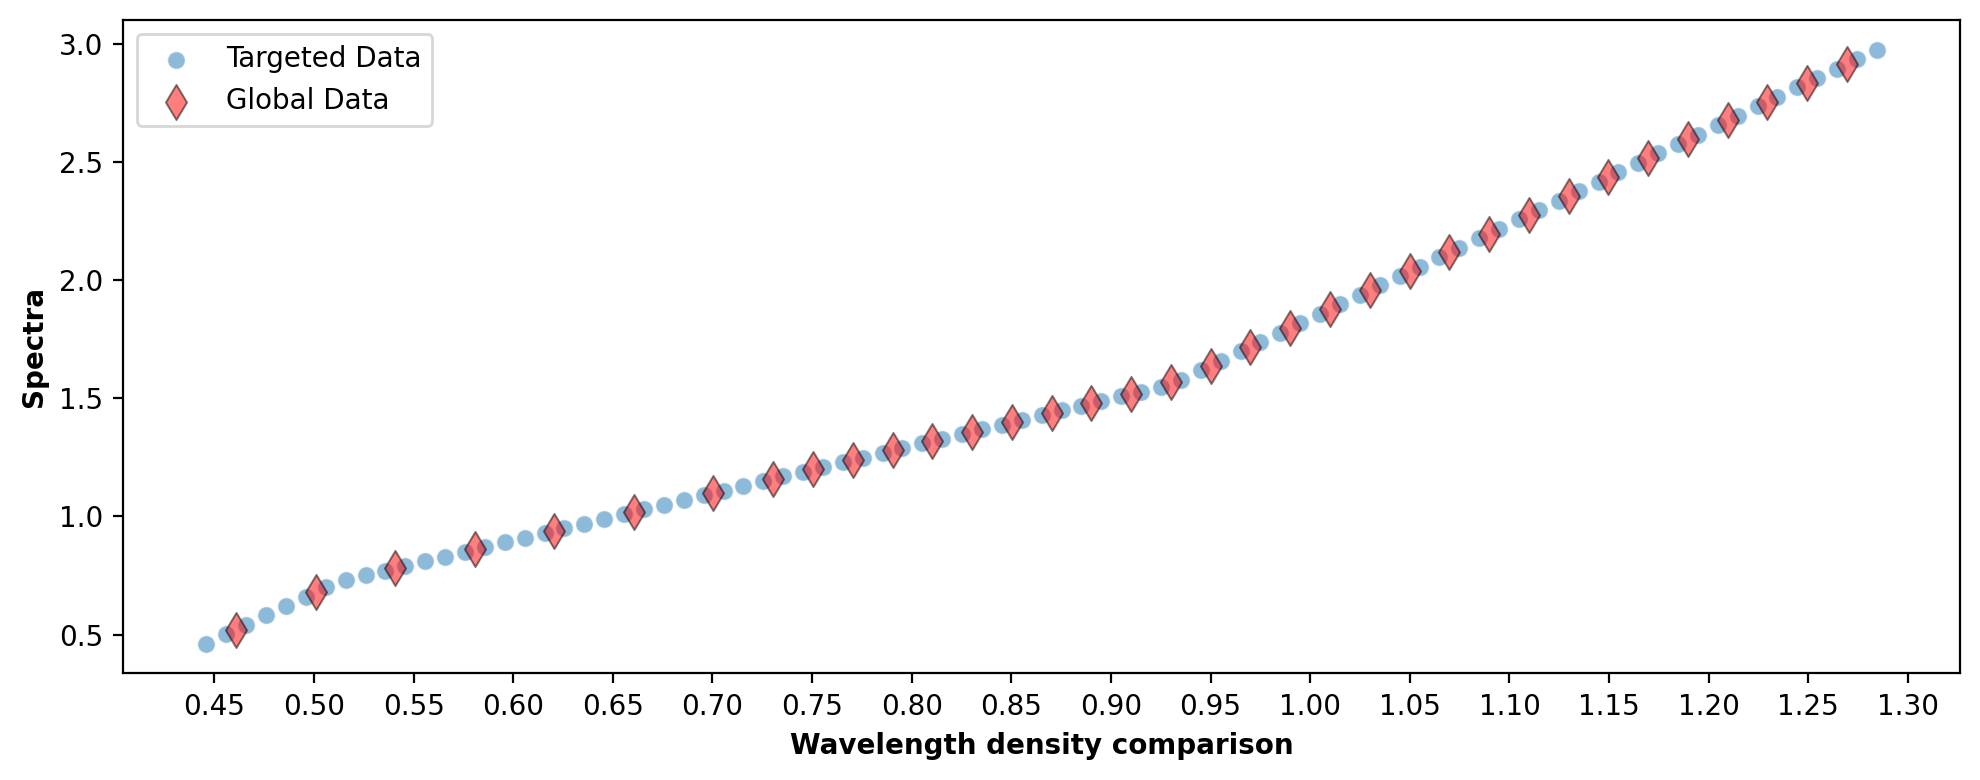

In [110]:
from matplotlib.ticker import MultipleLocator

plotting = True
if plotting:

    data = {
        "Targeted Data": {'wavelengths':wavelengths, 'spectra':spectra},
        "Global Data": targeted_to_global(wavelengths, spectra)
    }

    colors = ['#1f77b4', "#FF0000"]
    markers = ['o', 'd']
    sizes = [40, 80]
    edgecolors = ['white', 'black']

    fig, axes = plt.subplots(
        sharex=True, 
        figsize=(10, 4), 
    )

    for (label, contents), color, marker, size, edge in zip(data.items(), colors, markers, sizes, edgecolors):
        sns.scatterplot(
            x = contents['wavelengths'], 
            y = contents['spectra'],
            color = color,
            marker = marker,
            edgecolor = edge,
            s = size,
            alpha = 0.5,
            label = label
        )

    # last plot label acts as legend label
    axes.set_xlabel("Wavelength density comparison", weight = 'bold') 
    axes.set_ylabel("Spectra", weight = "bold")
    axes.xaxis.set_major_locator(MultipleLocator(0.05))
    axes.yaxis.set_major_locator(MultipleLocator(0.5))

    plt.tight_layout()

    # plt.savefig(
    #     "../output files/graphs/test/m3 wavelength comparison.png", 
    #     dpi=2000, 
    #     bbox_inches='tight',
    #     facecolor='white'
    # )

    plt.show() # calls plt.clf()

In [83]:
### file writing:
# check if output files/data_path exists
# prompt to create
# write file to output_path

def guess_output_path(input_path):
    parts = list(input_path.parts)
    for i in range(len(parts)-1,-1,-1):
        if parts[i] == "input files":
            return Path(*parts[:i]) / "output files"

def prompt_output_path(input_path):
    print("Folder 'output files' not found, create one (Y/N)? ")
    ans = input()
    while ans.lower() not in ["y", "n", "e"]:
        ans = input()
    if ans.lower() != "y":
        return None

    print("Enter # to create 'output files' folder in corresponding parent folder.")
    print("[#] folder name")
    for c, i in enumerate(output_path.parts):
        print(f"[{c}] {i}")
    ans = input()
    return Path(*list(output_path.parts)[:c]) / "output files"

def writeFile(data, filename, output_path, mode): 
    # x - new, w - overwrite
    output = open(output_path / filename, mode)
    output.write(f"header")
    for i in data:
        output.write(f"data formatted")
    output.close()

In [85]:
output = targeted_to_global(wavelengths, spectra, verbose=False)
output_path = ""
filename = data_path.name
saving = False

if input("Guess output path? (Y/N)").lower() == "y":
    output_path = guess_output_path(data_path)
    if output_path.exists():
        print(f"Saving to '{output_path}'.")
        saving = True
    else:
        print(f"Path not found, exiting.")
        saving = False
if not saving:
    output_path = prompt_output_path(data_path)
    if output_path and output_path.exists():
        print(f"Saving to '{output_path}'.")
        saving = True
    else:
        print(f"Path not recognized, exiting.")
        saving = False
if saving:
    try:
        writeFile(output, filename, output_path, mode = "x")
    except FileExistsError:
        print(f"File path already exists, overwrite (Y/N)?")
        ans = input()
        while ans.lower() not in ["y", "n"]:
            ans = input()
        if ans.lower() == "y":
            writeFile(output, filename, output_path, mode = "w")

Folder 'output files' not found, create one (Y/N)? 
Path not recognized, exiting.
